In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
os.chdir('/home/ali/packages/s2p-lbm/')

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu
from suite3d import file_utils as flu
from suite3d import extension as ext

/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/paramiko/transport.py:258: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


In [3]:
tif_dir = '/mnt/zeytin-f0/baruchin-data/1/1/'

In [4]:
tifs = tfu.get_tif_paths(tif_dir)

In [5]:
import tifffile

In [6]:


job_params = {    
    # number of channels recorded in the tiff file, typically 30
    'n_ch_tif' : 8,    
    'planes' : n.arange(8),
    'multiplane_2p_use_planes' : n.arange(2,8),
    # convert from the Scanimage channel ordering to deep-to-shallow ordering
    # in our case, ScanImage channel numbers are in temporal order. 
    'n_init_files' :   1,
    
    # volume rate in acquisition
    'fs' : 30 / 8,
    'fuse_strips' : False,
    
    # 3D GPU registration - fast! 
    # for now, 3D + GPU are well-tested, other options might have minor bugs
    # if you run into them, let us know! we'll fix them
    '3d_reg' : True,
    'gpu_reg' : True,
    'lbm' : False,
}

In [9]:
# Create the job
job = Job('/mnt/md0/runs','baruchin-1-newseg', tifs = tifs,
          params=job_params, create=True, overwrite=True, verbosity = 3)

Loading job directory for baruchin-1-newseg in /mnt/md0/runs
      Created dir /mnt/md0/runs/s3d-baruchin-1-newseg/registered_fused_data
      Created dir /mnt/md0/runs/s3d-baruchin-1-newseg/summary
      Created dir /mnt/md0/runs/s3d-baruchin-1-newseg/iters
   Loading default params
      Updating param n_ch_tif
      Updating param planes
      Updating param multiplane_2p_use_planes
      Updating param n_init_files
      Updating param fs
      Updating param fuse_strips
      Updating param 3d_reg
      Updating param gpu_reg
      Updating param lbm
   Updated main params file


In [10]:
# optional parameters for initialization
# load 1 file to initialize, and select 200 frames randomly to do initalization on
job.params['n_init_files'] = 3
job.params['init_n_frames'] = 400
job.params['init_file_sample_method'] = 'even'
job.params['voxel_size_um'] = (2,1,1)

In [11]:
%%time
summary = job.run_init_pass()

   Saved a copy of params at /mnt/md0/runs/s3d-baruchin-1-newseg/summary
   Updated main params file
Launching initial pass
Saving summary to /mnt/md0/runs/s3d-baruchin-1-newseg/summary/summary.npy
   Loading init tifs with 8 channels
      Loading tiff 1/3: /mnt/zeytin-f0/baruchin-data/1/1/file_00001_00004.tif
      Loading tiff 2/3: /mnt/zeytin-f0/baruchin-data/1/1/file_00001_00008.tif
      Loading tiff 3/3: /mnt/zeytin-f0/baruchin-data/1/1/file_00001_00011.tif
   Loaded 3 files, total 1.10 GB
   Selecting 400 random frames from the init tif files
   Loaded movie with 400 frames and shape 6, 256, 256
      Enforcing positivity in mean image
   No crosstalk estimation or subtraction
   Using 3d registration
   Computing plane alignment shifts
   Applying plane alignment shifts
   Launching 3D GPU reference image calculation
      Seeding reference image with most active frames
      Completed iter 1 out of 8 in  0.84s using  59/400 frames
      Completed iter 2 out of 8 in  0.66s usi

In [12]:
summary = job.load_summary()

In [13]:
img = summary['ref_img_3d']

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f7b71f8bc70>)

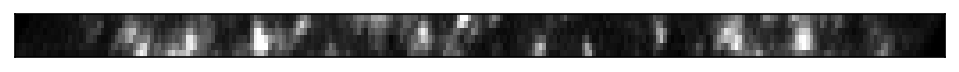

In [14]:
tfu.show_tif(img[:,130], px_py=(1,2))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7f7a48f76580>)

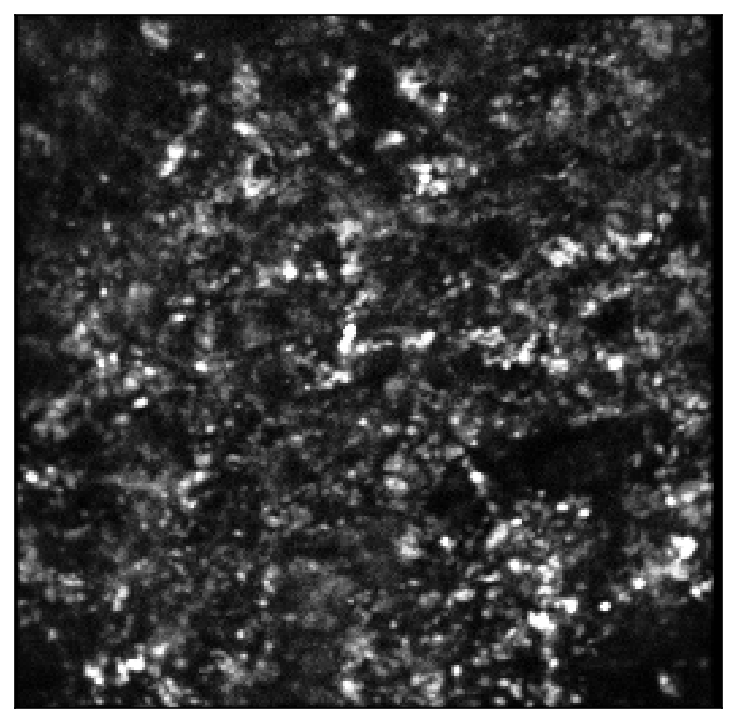

In [15]:
tfu.show_tif(img[3])

In [54]:
figdir = '/mnt/md0/s3d-figures/baruchin/'

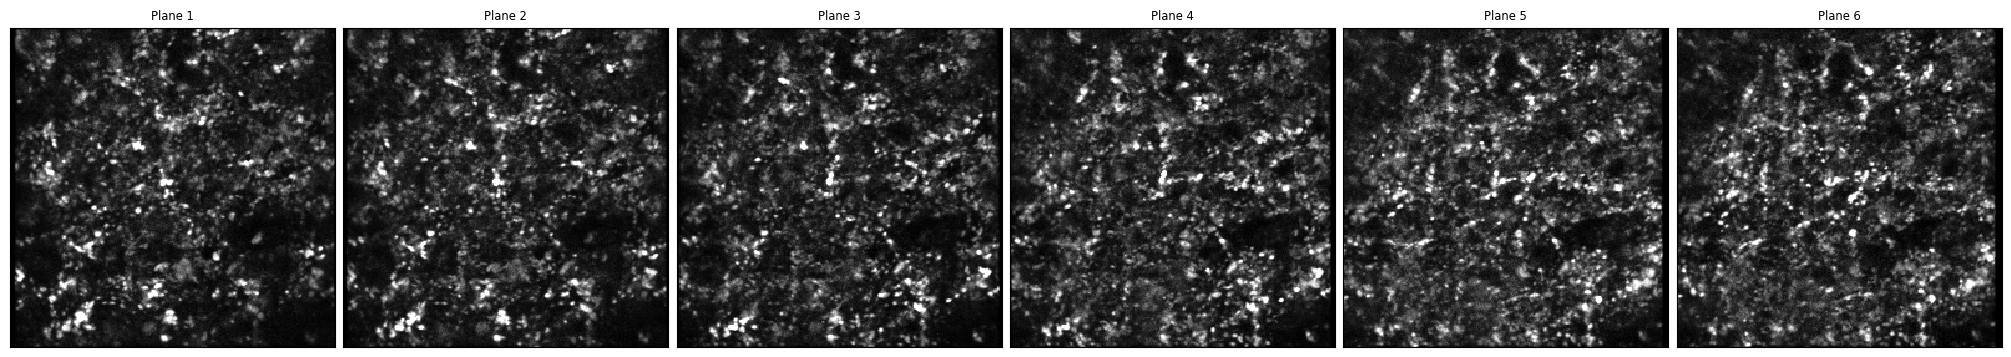

In [53]:
tfu.show_tif_all_planes(img,ncols=6, figsize=(20,5))

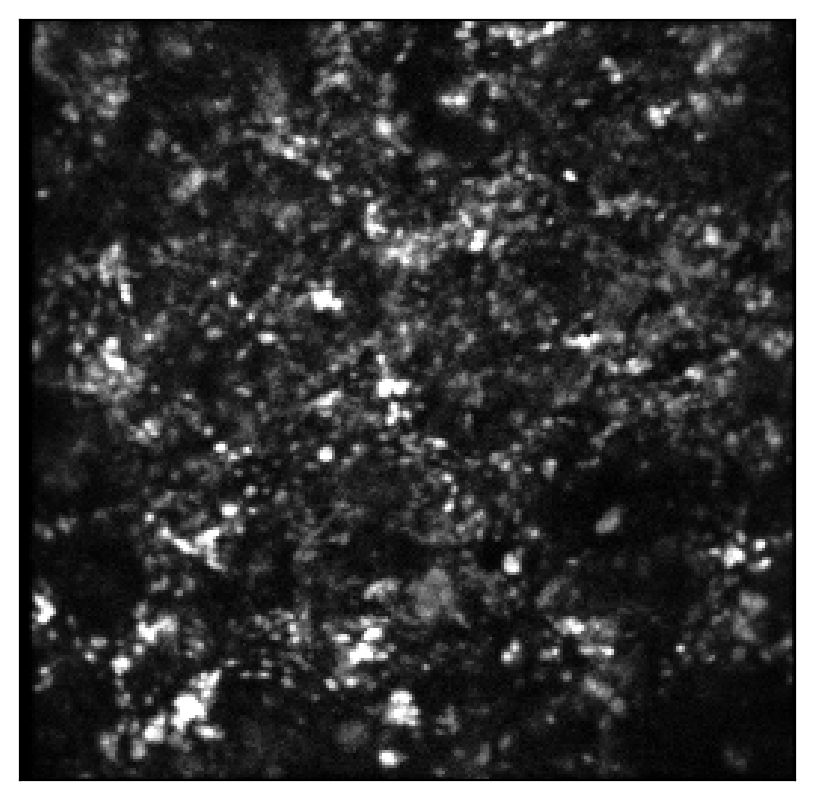

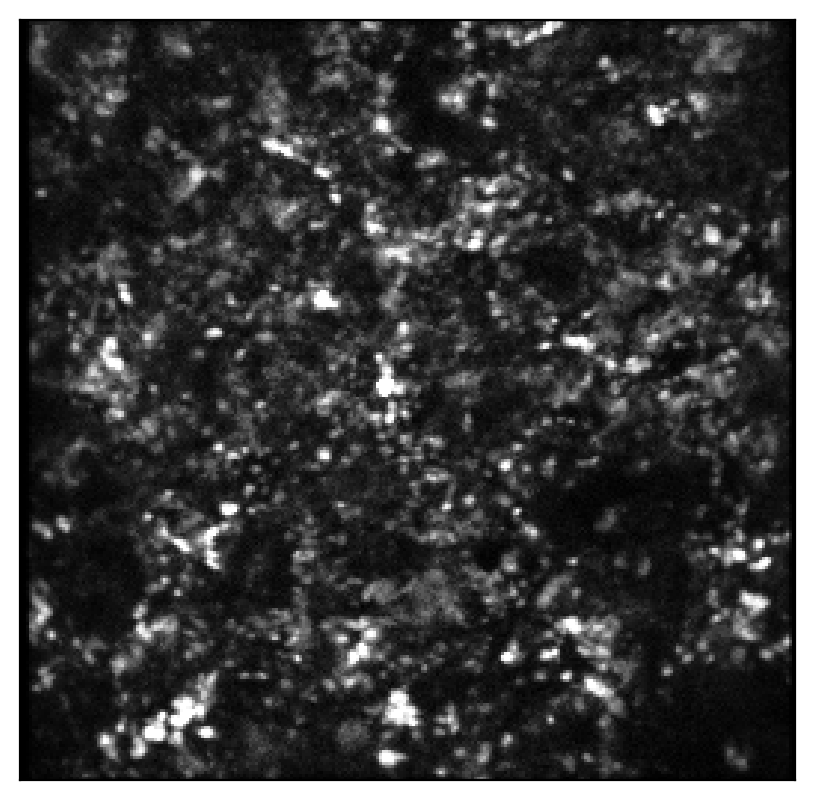

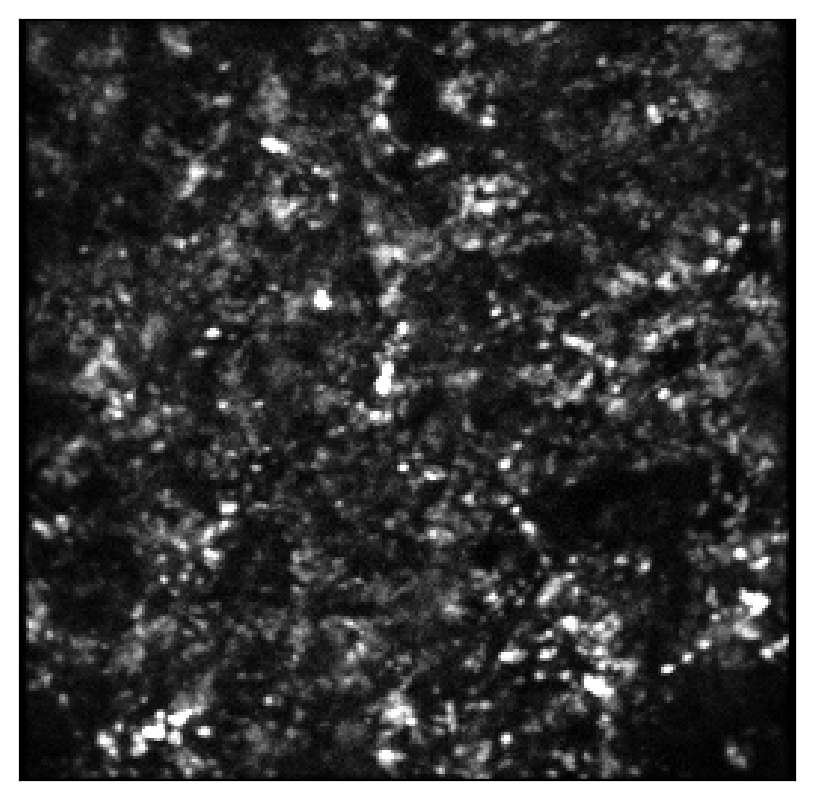

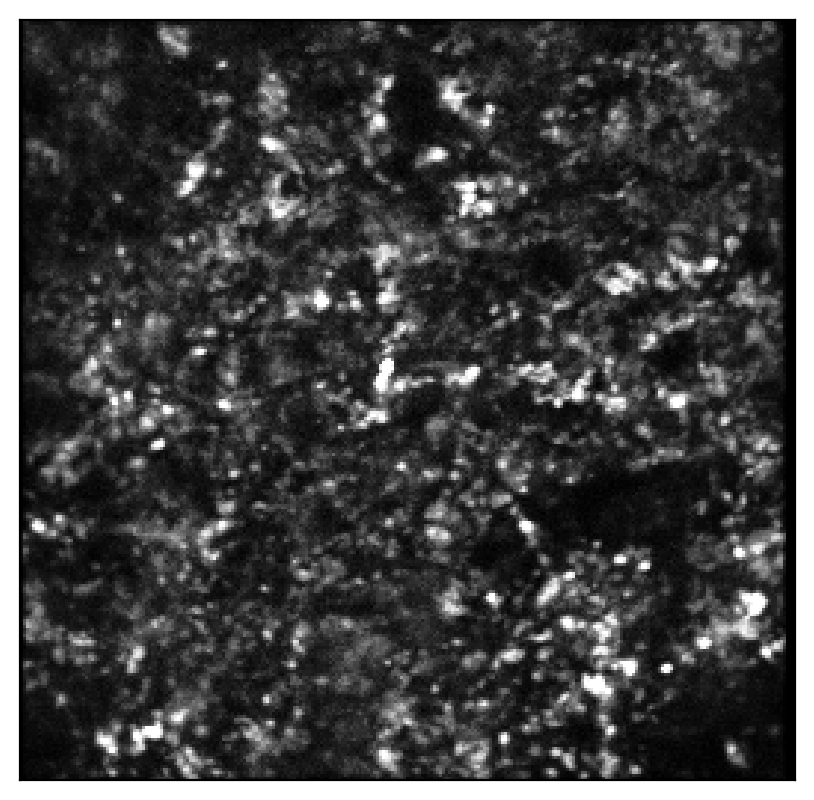

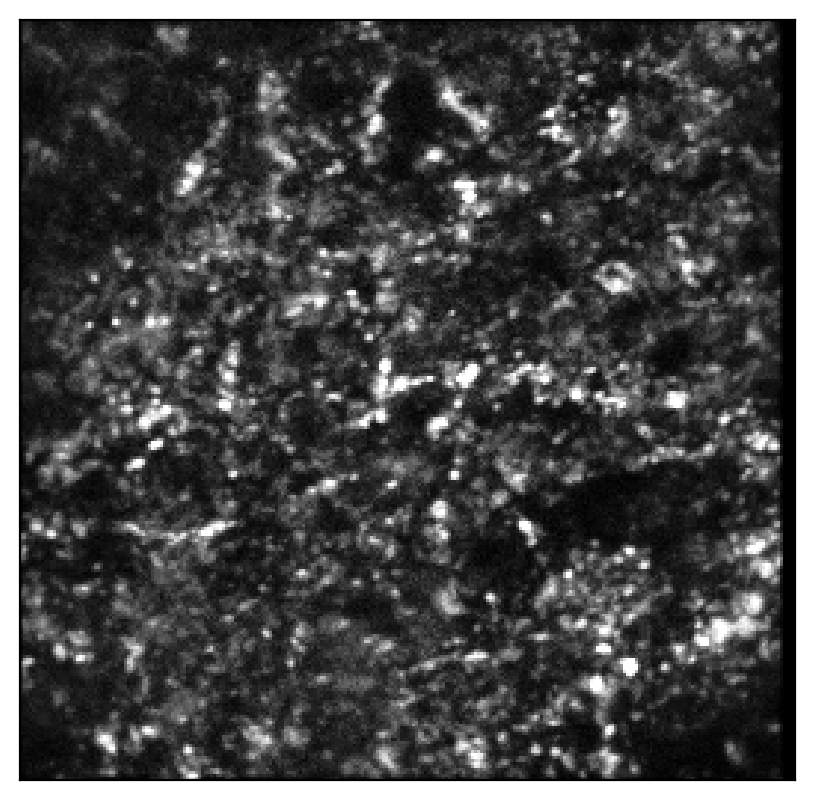

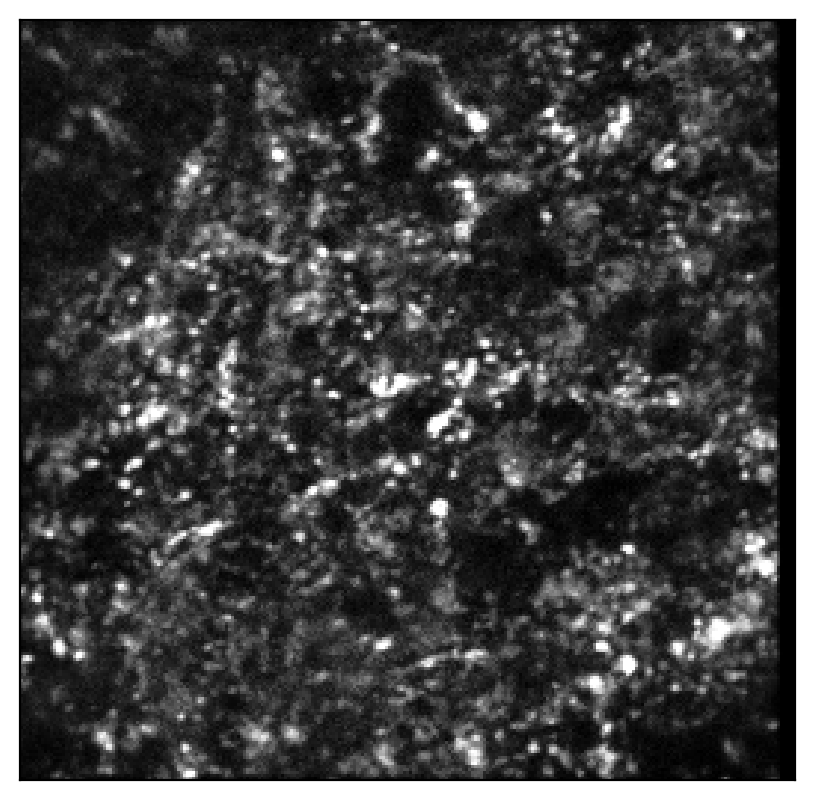

In [55]:
for i in range(6):
    f,ax = plt.subplots(figsize=(5,5),dpi=200)
    tfu.show_tif(img[i],ax=ax)
    plt.savefig(figdir + 'plane%d.svg' % i, bbox_inches='tight', pad_inches=0)    

In [17]:
# split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 1500

In [18]:
%%time
job.register()

      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/registered_fused_data
      Updating self.dirs tag registered_fused_data
   Saved a copy of params at /mnt/md0/runs/s3d-baruchin-1-newseg/registered_fused_data
   Updated main params file
   Starting registration: 3D: True, GPU: True
   Not clipping frames for registration
Will analyze 14 tifs in 14 batches
   Enforcing positivity
   Launching IO thread
         Memory at batch 0.  Total Used: 145.565 GB, Virtual Available: 357.631 GB, Virtual Used: 145.565 GB, Swap Used: 000.000 GB
Loading Batch 0 of 13
      Loading tiff 1/1: /mnt/zeytin-f0/baruchin-data/1/1/file_00001_00001.tif
   Loaded 1 files, total 0.37 GB
   Batch 0 IO thread joined
         Memory after IO thread joinTotal Used: 145.940 GB, Virtual Available: 357.256 GB, Virtual Used: 145.940 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 146.308 GB, Virtual Available: 356.888 GB, Virtual Used: 146.308 GB, Swap Used: 000.000 GB
         Me

/home/ali/packages/s2p-lbm/suite3d/quality_metrics.py:41: RuntimeWarning: invalid value encountered in divide
  dff = df / fs.mean(axis=1,keepdims=True)
/home/ali/anaconda3/envs/suite3d-gpu/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


         After full batch saving:Total Used: 147.217 GB, Virtual Available: 355.978 GB, Virtual Used: 147.217 GB, Swap Used: 000.000 GB
         Memory at batch 1.  Total Used: 147.217 GB, Virtual Available: 355.978 GB, Virtual Used: 147.217 GB, Swap Used: 000.000 GB
Loading Batch 1 of 13
   Loaded 1 files, total 0.37 GB
   Batch 1 IO thread joined
         Memory after IO thread joinTotal Used: 147.576 GB, Virtual Available: 355.619 GB, Virtual Used: 147.576 GB, Swap Used: 000.000 GB
         Memory after movie copied from threadTotal Used: 147.197 GB, Virtual Available: 355.999 GB, Virtual Used: 147.197 GB, Swap Used: 000.000 GB
         Memory after thread memory clearedTotal Used: 146.824 GB, Virtual Available: 356.372 GB, Virtual Used: 146.824 GB, Swap Used: 000.000 GB
   Launching IO thread for next batch
         After IO thread launch:Total Used: 146.824 GB, Virtual Available: 356.372 GB, Virtual Used: 146.824 GB, Swap Used: 000.000 GB
      Loaded batch of size (6, 500, 256, 2

In [19]:
reg3d = job.load_registration_results()

In [20]:
mov_full = job.get_registered_movie('registered_fused_data', 'fused')
im_full = mov_full[:,:200].mean(axis=1).compute()

In [37]:
subpix = n.concatenate(reg3d['sub_pixel_shifts'],axis=0)

In [39]:
job.params['cell_filt_type'] = 'gaussian'

job.params['voxel_size_um'] = (2, 1, 1)
job.params['npil_filt_xy_um'] = 70
job.params['cell_filt_xy_um'] = 1
job.params['cell_filt_z_um'] = 1
job.params['sdnorm_exp'] = 1.0
job.params['t_batch_size'] = 1000

In [40]:
%%time
corr_map = job.calculate_corr_map()

      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/corrmap
      Updating self.dirs tag corrmap
      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/mov_sub
      Updating self.dirs tag mov_sub
   Saved a copy of params at /mnt/md0/runs/s3d-baruchin-1-newseg/corrmap
   Updated main params file
   Computing correlation map of movie with 6626 frames, volume shape: 6, 256, 261
      Running batch 1 of 7
         Timer prep completed in 1.148 sec
         Timer batch_setup completed in 0.375 sec
         Timer batch_edgecrop completed in 0.055 sec
         Timer accum_meanmeax completed in 0.306 sec
         Timer batch_rolling_mean_filt completed in 0.301 sec
         Timer batch_accum_sdmov completed in 0.925 sec
         Timer batch_norm_sdmov completed in 0.155 sec
         Loading movie into shared memory
         Timer dtu_shmem completed in 1.209 sec
         Subtracting neuropil and applying cell filters
         Timer dtu_npsub_conv3d completed in 1.252 sec
         Reducing filte

In [41]:
res = job.load_corr_map_results()
vmap = res['vmap']
vmap = ext.thresh_mask_corr_map(vmap)

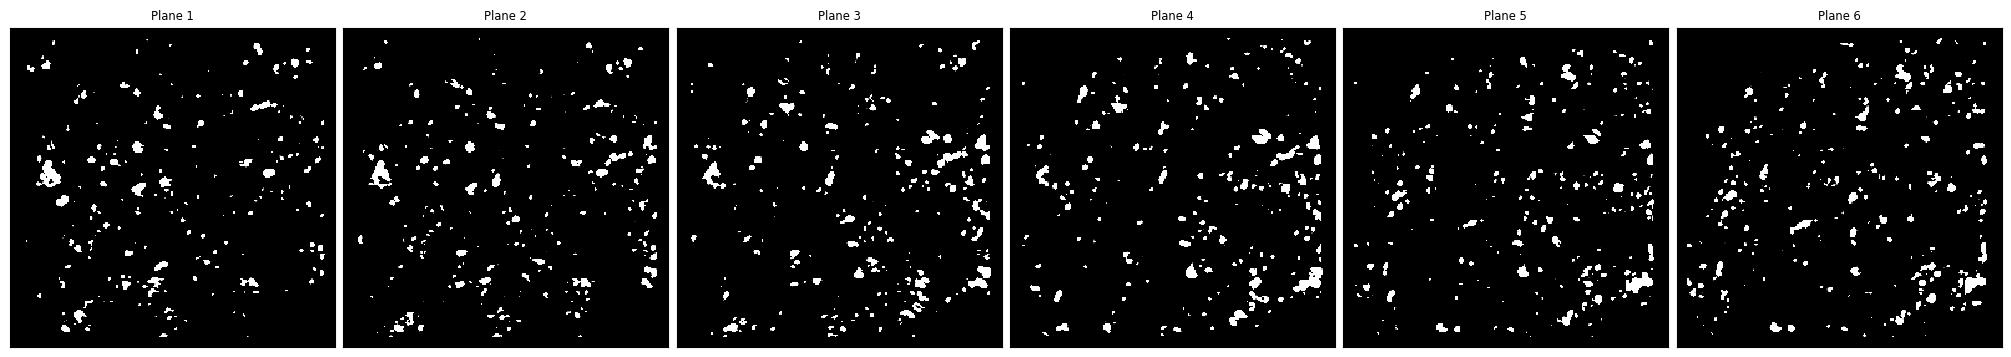

In [42]:
tfu.show_tif_all_planes(vmap, ncols=6, figsize=(20,4), vminmax=(0.02, 0.021))

In [43]:
%%time
job.params['peak_thresh'] = 0.02
# optionally, bin the movie in time to speed up detection
# probably a good idea if you have high framerate (>5 Hz?)
job.params['detection_timebin'] = 1

# when extending an ROI, compare its activity to its neighboring pixels
# in frames where the fluorescence is above this percentile
job.params['percentile'] = 99.0

job.params['extend_thresh'] = 0.05
job.params['activity_thresh'] = 4.0
job.params['max_iter'] = 1000
job.params['ext_subtract_iters'] = 3
job.params['n_proc_detect'] = 64
job.params['patch_size_xy'] = (300, 300)

# corr_map = job.load_corr_map_results()['vmap']
job.segment_rois(vmap=vmap)

      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/segmentation
      Updating self.dirs tag segmentation
   Saved a copy of params at /mnt/md0/runs/s3d-baruchin-1-newseg/segmentation
   Updated main params file
      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/rois
      Updating self.dirs tag rois
   Saving results to /mnt/md0/runs/s3d-baruchin-1-newseg/segmentation and /mnt/md0/runs/s3d-baruchin-1-newseg/rois 
dict_keys(['max_img', 'mean_img', 'vmap', 'all_params'])
   Detecting from patch 1 / 1
      Found dir /mnt/md0/runs/s3d-baruchin-1-newseg/segmentation/patch-0000
         Loading 4.95 GB movie to memory, shape: (6626, 6, 256, 261) 
         Loaded
         Loading movie patch to shared memory
         Loaded
      Starting extraction with peak_thresh: 0.020 and Th2: 4.000
         Iter 0000: running 64 ROIs in parallel
         Added cell 1 at 05, 204, 235, peak: 0.153, thresh: 3.926, 905 frames, 858 pixels
         Added cell 2 at 00, 115, 032, peak: 0.132, thresh: 3.367,

'/mnt/md0/runs/s3d-baruchin-1-newseg/rois'

In [46]:
import  colorcet
from suite3d import plot_utils as plot
from suite3d import nbtools as nbui


seg = job.load_segmentation_results()
cell_id_vol, rgb_vol = ui.make_label_vols(seg['stats'], vmap.shape, lam_max=0.075, cmap='cet_glasbey_dark')
nbui.ImageSliceViewer3D(vmap, overlay=rgb_vol,cmap='Greys')

      Loading from /mnt/md0/runs/s3d-baruchin-1-newseg/rois/info.npy
      Loading from /mnt/md0/runs/s3d-baruchin-1-newseg/rois/stats.npy
      Loading from /mnt/md0/runs/s3d-baruchin-1-newseg/rois/iscell.npy


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [124]:
nbui.ImageSliceViewer3D(vmap, overlay=rgb_vol,cmap='Greys')

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [125]:
nbui.ImageSliceViewer3D(vmap, overlay=rgb_vol,cmap='Greys')

interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

In [47]:
# filt = npix > -1
filt = n.ones(len(seg['stats']))

n_files = 8
shuff_cells = n.where(filt)[0]
n.random.shuffle(shuff_cells)
nc = len(shuff_cells)
batchsize = nc // n_files
for i in range(n_files):
    cx = shuff_cells[i*batchsize:i*batchsize + batchsize]
    filefilt = n.zeros_like(filt)
    filefilt[cx] = True

    __, filevol = ui.make_label_vols(seg['stats'], corr_map.shape, lam_max=1.0, cmap='cet_glasbey_dark',
                                             iscell = filefilt)
    tfu.save_mrc('/mnt/md0/runs/pub-figs/',f'baruchin-boutons_c{i:02d}.mrc', filevol[:,:,:,-1],
            voxel_size=(0.33, 0.33, 2))

In [50]:
job.compute_npil_masks(job.dirs['rois'])

'/mnt/md0/runs/s3d-baruchin-1-newseg/rois'

In [52]:

traces = job.extract_and_deconvolve(stats_dir=job.dirs['rois'],iscell=None)

   Updated main params file
   Movie shape: (6, 6626, 256, 261)
604
   Extracting 604 valid cells, and saving cell flags to /mnt/md0/runs/s3d-baruchin-1-newseg/rois/iscell_extracted.npy
   Extracting activity
         Will extract in 14 batches of 500
   Saving intermediate results to /mnt/md0/runs/s3d-baruchin-1-newseg/rois
   Deconvolving
   Saving to /mnt/md0/runs/s3d-baruchin-1-newseg/rois


In [ ]:
job.export_results('/mnt/zeytin-f1/s3d-results/',result_dir_name='rois')